In [3]:
import numpy as np
import cv2
import imutils
from imutils import contours
import math
import matplotlib.pyplot as plt

Micron to Pixel Value

This value was provided by Heidi Sosik via the IFCB User Group Message Board. There may be some variance between IFCBs so it is advised that users run a beads solution and the pixel values of beads of a known size.

In [4]:
MICRON_TO_PIXEL_VALUE = 2.77

Python Only

This approach creates a new image with the measurements embded in the image itself. There is an issue where the measurements can appear outside of the image confines.

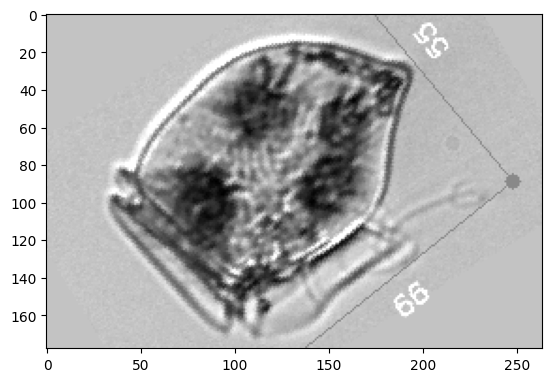

In [9]:
image_data = cv2.imread('./images/Dinophysis/dino_test.png', )
image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)


edged = cv2.Canny(image_data, 50, 100)
#edged = cv2.Canny(img, 10, 25)
edged = cv2.dilate(edged, None, iterations=4)
edged = cv2.erode(edged, None, iterations=4)
#cv2.imshow('edged.png', edged)
#find contours
conts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
conts = imutils.grab_contours(conts)
(conts, _) = contours.sort_contours(conts)

rect_list = []

for (i,c) in enumerate(conts):
    if cv2.contourArea(c) < 150:
        continue

    box = cv2.minAreaRect(c)
    (x, y), (width, height), angle = box

    #get dimensions of box
    main_x = x
    main_y = y
    length_rotation = 90 - angle
    width_rotation = 180 - angle
    

    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")


    #draw bounding rectangle
    #cv2.drawContours(img, [box], -1, (0,255,0), 1)

    #draw left and bottom lines only 
    cv2.line(image_data,box[1],box[2],(150,150,150),1 )
    cv2.line(image_data,box[2],box[3],(150,150,150),1 )
    cv2.circle(image_data, box[1], 4, (150,150,150), -1)
    cv2.circle(image_data, box[2], 4, (150,150,150), -1)
    cv2.circle(image_data, box[3], 4, (150,150,150), -1)

    #work out length and width in pixels
    length_pixels = math.dist(box[0], box[1])
    width_pixels = math.dist(box[1], box[2])

    #convert pixel lengths to microns
    length = round(length_pixels / MICRON_TO_PIXEL_VALUE)
    width = round(width_pixels / MICRON_TO_PIXEL_VALUE)
    
    #offset values for positioning of labels
    length_offset = (width_pixels / 2) + 20
    width_offset = (length_pixels / 2) + 20

    # #get rotation amounts for text labels
    length_rotation_matrix = cv2.getRotationMatrix2D((main_x, main_y), length_rotation, 1)
    width_rotattion_matrix = cv2.getRotationMatrix2D((main_x, main_y), width_rotation, 1)

    # #generate length text and rotate it - then crop to original image size
    length_text_img = np.zeros((1000,1000))
    cv2.putText(length_text_img, str(length) ,(int(main_x ), int(main_y + length_offset)), cv2.FONT_HERSHEY_SIMPLEX, .5, (255, 255, 255), 1, cv2.LINE_AA)
    rotated_text_img = cv2.warpAffine(length_text_img, length_rotation_matrix, (10000, 10000))
    rotated_text_img = rotated_text_img[0:image_data.shape[0], 0:image_data.shape[1]]
    
    # #generate width text and rotate it - then crop to original image size
    width_text_img = np.zeros((1000,1000))
    cv2.putText(width_text_img, str(width) ,(int(main_x), int(main_y  + width_offset)), cv2.FONT_HERSHEY_SIMPLEX, .5, (255, 255, 255), 1, cv2.LINE_AA)
    width_rotated_text_img = cv2.warpAffine(width_text_img, width_rotattion_matrix, (1000, 1000))
    width_rotated_text_img = width_rotated_text_img[0:image_data.shape[0], 0:image_data.shape[1]]
    
    #add rotated text images to original image
    image_data = cv2.add(image_data ,rotated_text_img, dtype=8)
    image_data = cv2.add(image_data ,width_rotated_text_img, dtype=8)

    #format is top_right_x, top_right_y, botttom_right_c, bottom_right_y, bottom_left_x, bottom_left_y, angle, length_in_pix, wide_in_pix
    rect_list.append([ box[1][0], box[1][1], box[2][0], box[2][1], box[3][0], box[3][1], angle, length_pixels, width_pixels]) 


plt.imshow(image_data, cmap='gray')



Python + JavaScript

It is actually much better just to have the Python sript generate the values for the bounding rectangles and then pass these (using Django or Flask) to client-side JavaScript for rendering. An example of the JavaScript required to render the image with measurements can be found in image_measurements.html

A lot of the Canny edge detection settings were derived through experimentation. They can likely be tweaked to improve object detection in the image.

In [5]:

def measure_image(image_path):
    #read in image data and convert to grayscale
    image_data = cv2.imread(image_path)
    image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)

    edged = cv2.Canny(image_data, 50, 100)
    edged = cv2.dilate(edged, None, iterations=4)
    edged = cv2.erode(edged, None, iterations=4)
    
    #find contours
    conts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    conts = imutils.grab_contours(conts)
    (conts, _) = contours.sort_contours(conts)

    rect_list = []

    for (i,c) in enumerate(conts):
        if cv2.contourArea(c) < 150:
            continue

        box = cv2.minAreaRect(c)
        (x, y), (width, height), angle = box
    
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")

        #work out length and width in pixels
        length_pixels = math.dist(box[0], box[1])
        width_pixels = math.dist(box[1], box[2])


        #format is top_right_x, top_right_y, botttom_right_c, bottom_right_y, bottom_left_x, bottom_left_y, angle, length_in_pix, wide_in_pix
        rect_list.append([ box[1][0], box[1][1], box[2][0], box[2][1], box[3][0], box[3][1], angle, length_pixels, width_pixels]) 


    return image_path, rect_list

In [7]:
#prints masurements for a 6 micron bead
print(measure_image('./images/bead/D20240228T113410_IFCB147_00867.png'))

('./images/bead/D20240228T113410_IFCB147_00867.png', [[35, 19, 52, 19, 52, 37, 0.0, 18.0, 17.0]])
